In [1]:
import torch
import os
import mlflow
import numpy as np
import matplotlib as mpl
from ultralytics import YOLO
import ultralytics
import pycocotools.coco
import pycocowriter.coco2yolo
import requests
import sys
from hierarchical_yolo.hierarchical_detection import *
from hierarchical_yolo.deep7_model import *

In [2]:
torch.sum(torch.nn.functional.logsigmoid(torch.tensor([[40.,1000.,20.],[1.,2.,3.]])), dim=1)

tensor([-2.0612e-09, -4.8878e-01])

In [3]:
'''
deep7 categories:

  0: Kalekale
  1: Opakapaka
  2: "Hapu\u02BBupu\u02BBu"
  3: Gindai
  4: Other or Can't Tell
  5: Ehu
  6: Lehi
  7: Onaga
  8: Snapper
  9: Grouper
  10: Object
'''

deep7_hierarchy = {
    0: 8,
    1: 8,
    2: 9,
    3: 8,
    5: 8,
    6: 8,
    7: 8,
    4: 10,
    8: 10,
    9: 10
}

In [4]:
'''
deep7 categories:

  0: Kalekale
  1: Opakapaka
  2: "Hapu\u02BBupu\u02BBu"
  3: Gindai
  4: Fish
  5: Ehu
  6: Lehi
  7: Onaga
'''

deep7_hierarchy = {
    0: 4,
    1: 4,
    2: 4,
    3: 4,
    5: 4,
    6: 4,
    7: 4
}

In [5]:
from ultralytics import settings

# View all settings
print(settings)

JSONDict("/home/noaa_brown/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/home/noaa_brown/datasets",
  "weights_dir": "/home/noaa_brown/hierarchical_yolo/weights",
  "runs_dir": "/home/noaa_brown/hierarchical_yolo/runs",
  "uuid": "2768c477e7938b5779aff75aed83103f60cf5680dbe7372dfa0b27c233b7d105",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}


In [6]:
devices = list(range(torch.cuda.device_count()))
for i in devices:
    print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti


In [7]:
DATA = '../data'
UPLOAD_URL = 'https://storage.googleapis.com/nmfs_odp_hq/nodd_tools/datasets/oceaneyes/annotation_number_balanced_sample/annotations.json'
DOWNLOAD_PATH = os.path.join(DATA, 'download')
COCO_PATH = os.path.join(DOWNLOAD_PATH, 'annotations.json')
YOLO_PATH = os.path.join(DOWNLOAD_PATH, 'yolo_training_data')
IMAGES_PATH = os.path.join(YOLO_PATH, 'annotations', 'images')
os.makedirs(YOLO_PATH, exist_ok=True)
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

In [8]:
uploaded_coco_file = requests.get(UPLOAD_URL)
with open(COCO_PATH, 'wb') as f:
    f.write(uploaded_coco_file.content)
    coco = pycocotools.coco.COCO(COCO_PATH)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [9]:
coco.info()

year: 2024
version: 0.1
description: https://www.zooniverse.org/projects/benjamin-dot-richards/oceaneyes/about/research
contributor: None
url: None
date_created: 2025-02-06T20:56:54.886937+00:00


In [10]:
pycocowriter.coco2yolo.coco2yolo(DOWNLOAD_PATH, YOLO_PATH)

Annotations /home/noaa_brown/hierarchical_yolo/data/download/annotations.json: 100%|██████████| 200/200 [00:00<00:00, 1077.02it/s]

COCO data converted successfully.
Results saved to /home/noaa_brown/hierarchical_yolo/notebooks/coco_converted


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
downloaded 0/200 images (t=0.0s)
downloaded 1/200 images (t=0.0s)
downloaded 2/200 images (t=0.0s)
downloaded 3/200 images (t=0.0s)
downloaded 4/200 images (t=0.0s)
downloaded 5/200 images (t=0.0s)
downloaded 6/200 images (t=0.0s)
downloaded 7/200 images (t=0.0s)
downloaded 8/200 images (t=0.0s)
downloaded 9/200 images (t=0.0s)
downloaded 10/200 images (t=0.0s)
downloaded 11/200 images (t=0.0s)
downloaded 12/200 images (t=0.0s)
downloaded 13/200 images (t=0.0s)
downloaded 14/200 images (t=0.0s)
downloaded 15/200 images (t=0.0s)
downloaded 16/200 images (t=0.0s)
downloaded 17/200 images (t=0.0s)
downloaded 18/200 images (t=0.0s)
downloaded 19/200 images (t=0.0s)
downloaded 20/200 images (t=0.0s)
downloaded 21/200 images (t=0.0s)
downloaded 22/200 images (t=0.0s)
downloaded 23/200 images (t=0.0s)
downloaded 24/200 images (t=

In [11]:
# TODO: the yolov8.yaml model file downloaded from Ultralytics needs manual editing for the number of classes
YOLO_YAML = os.path.join(DATA, 'yolov8.yaml')
YOLO_BASE_MODEL = os.path.join(DATA, 'yolov8n.pt')
YOLO_TRAIN_YAML = os.path.join(YOLO_PATH, 'train.yaml')

In [12]:
mlflow.autolog()

In [13]:
model = YOLO(YOLO_YAML).load(YOLO_BASE_MODEL)  # build a new model from scratch

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 319/355 items from pretrained weights


In [14]:
results = model.train(
    data=YOLO_TRAIN_YAML, 
    epochs=5, imgsz=640, 
    device=devices, 
    batch=max(len(devices), 1),
    trainer=Deep7HierarchicalDetectionTrainer
)

New https://pypi.org/project/ultralytics/8.3.113 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.104 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:2 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:3 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:4 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:5 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:6 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
engine/trainer: task=detect, mode=train, model=../data/yolov8.yaml, data=../data/download/yolo_training_data/train.yaml, epochs=5, time=None, patience=100, batch=7, imgsz=640, save=True, save_

train: Scanning /home/noaa_brown/hierarchical_yolo/data/download/yolo_training_data/annotations/labels.cache... 200 images, 0 backgrounds, 1 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


train: WARNING ⚠️ /home/noaa_brown/hierarchical_yolo/data/download/yolo_training_data/annotations/images/20190913_201709_20190913.203153.002.010131.jpg: ignoring corrupt image/label: negative label values [-0.00068681]
train: WARNING ⚠️ /home/noaa_brown/hierarchical_yolo/data/download/yolo_training_data/annotations/images/20190913_201709_20190913.203153.002.010131.jpg: ignoring corrupt image/label: negative label values [-0.00068681]


val: Scanning /home/noaa_brown/hierarchical_yolo/data/download/yolo_training_data/annotations/labels.cache... 200 images, 0 backgrounds, 1 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to /home/noaa_brown/hierarchical_yolo/runs/detect/train79/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004921875), 63 bias(decay=0.0)
MLflow: logging run_id(0ee3bc68c27c4e9284535271007071bb) to /home/noaa_brown/hierarchical_yolo/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /home/noaa_brown/hierarchical_yolo/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 14 dataloader workers
Logging results to /home/noaa_brown/hierarchical_yolo/runs/detect/train79
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/29 [00:00<?, ?it/s]

{torch.Size([1, 8400, 8]): 1}


        1/5     0.281G      2.838      4.481      1.711        115        640: 100%|██████████| 29/29 [00:05<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   1%|          | 1/100 [00:00<00:12,  8.07it/s]

{torch.Size([2, 7056, 8]): 1}


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:03<00:00, 25.67it/s]


                   all        199       6757    0.00157    0.00689     0.0023    0.00114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5     0.301G      2.476      3.648      1.391        118        640: 100%|██████████| 29/29 [00:04<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:03<00:00, 25.49it/s]


                   all        199       6757     0.0256      0.121     0.0408     0.0183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5     0.318G      2.267      2.814      1.348         44        640: 100%|██████████| 29/29 [00:04<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


                   all        199       6757      0.585     0.0861     0.0535     0.0236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5     0.318G      2.393      2.815      1.338         56        640: 100%|██████████| 29/29 [00:04<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


                   all        199       6757      0.719     0.0875     0.0583      0.026

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5     0.318G      2.287      2.854      1.297         34        640: 100%|██████████| 29/29 [00:04<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


                   all        199       6757      0.595      0.095     0.0607     0.0279

5 epochs completed in 0.012 hours.
Optimizer stripped from /home/noaa_brown/hierarchical_yolo/runs/detect/train79/weights/last.pt, 6.2MB
Optimizer stripped from /home/noaa_brown/hierarchical_yolo/runs/detect/train79/weights/best.pt, 6.2MB

Validating /home/noaa_brown/hierarchical_yolo/runs/detect/train79/weights/best.pt...
Ultralytics 8.3.104 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:2 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:3 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:4 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:5 (NVIDIA GeForce GTX

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:03<00:00, 32.70it/s]


                   all        199       6757      0.595     0.0955     0.0608      0.028
              Kalekale         28        155          0          0     0.0155    0.00822
             Opakapaka         46        269      0.105     0.0967     0.0467     0.0248
            Hapuʻupuʻu          1          1          1          0          0          0
                Gindai         18        144          1          0          0          0
   Other or Can't Tell        177       3673       0.29      0.233      0.142     0.0641
                   Ehu        104       2500      0.362      0.434      0.281      0.126
                  Lehi          3          7          1          0    0.00052   0.000364
                 Onaga          3          8          1          0   0.000599    0.00042
Speed: 0.3ms preprocess, 5.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to /home/noaa_brown/hierarchical_yolo/runs/detect/train79
MLflow: results logged to /home/noaa_brown/hi

In [15]:
random_img = os.path.join(IMAGES_PATH, str(np.random.choice(os.listdir(IMAGES_PATH))))
random_img

'../data/download/yolo_training_data/annotations/images/20190925_202536_20190925.203825.326.008754.jpg'

In [16]:
MODEL_LOCATION = os.path.join('..','runs','detect')
trained_models = os.listdir(os.path.join('..','runs','detect'))
model_numbers = map(lambda x: int(x[len('train'):]) if len(x) > len('train') else 0, trained_models)
latest_model = 'train' + str(max(model_numbers))

In [17]:
trained_model = YOLO(
    YOLO_YAML
).load(os.path.join(MODEL_LOCATION, latest_model, 'weights', 'best.pt'))

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 355/355 items from pretrained weights


In [18]:
predictions = trained_model.predict(random_img, verbose=False, device=devices[:1], stream=True)

In [19]:
prediction = next(predictions)

In [20]:
prediction

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7'}
obb: None
orig_img: array([[[94, 94, 94],
        [93, 93, 93],
        [94, 94, 94],
        ...,
        [80, 80, 80],
        [78, 78, 78],
        [76, 76, 76]],

       [[86, 86, 86],
        [85, 85, 85],
        [86, 86, 86],
        ...,
        [80, 80, 80],
        [78, 78, 78],
        [76, 76, 76]],

       [[78, 78, 78],
        [77, 77, 77],
        [78, 78, 78],
        ...,
        [81, 81, 81],
        [79, 79, 79],
        [77, 77, 77]],

       ...,

       [[54, 54, 54],
        [55, 55, 55],
        [56, 56, 56],
        ...,
        [24, 24, 24],
        [24, 24, 24],
        [24, 24, 24]],

       [[51, 51, 51],
        [52, 52, 52],
        [53, 53, 53],
        ...,
        [23, 23, 23],
        [23, 23, 23],
        [23, 23, 23]],

       [[49, 49, 49],
   

In [21]:
prediction.boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 5., 5., 5.], device='cuda:0')
conf: tensor([0.8625, 0.7738, 0.6940, 0.6872, 0.6577, 0.6225, 0.5087, 0.4925, 0.4899, 0.4192, 0.4144, 0.2909, 0.2862, 0.2712], device='cuda:0')
data: tensor([[2.0131e+02, 6.4528e+02, 2.4606e+02, 6.9994e+02, 8.6252e-01, 5.0000e+00],
        [9.9915e+01, 5.2260e+02, 1.8443e+02, 6.4338e+02, 7.7384e-01, 5.0000e+00],
        [3.8533e+02, 4.7064e+02, 4.2697e+02, 5.1486e+02, 6.9401e-01, 5.0000e+00],
        [4.2120e+02, 4.5869e+02, 5.0066e+02, 5.6948e+02, 6.8716e-01, 5.0000e+00],
        [6.4975e+01, 6.5193e+02, 1.3912e+02, 7.1367e+02, 6.5773e-01, 5.0000e+00],
        [4.8840e+00, 2.6449e+02, 9.6856e+01, 3.5428e+02, 6.2249e-01, 5.0000e+00],
        [3.2213e+02, 2.8253e+02, 4.0448e+02, 3.7916e+02, 5.0868e-01, 5.0000e+00],
        [4.8975e+02, 6.2112e+02, 5.4681e+02, 7.0446e+02, 4.9250e-01, 5.0000e+00],
        [2.7561e+02, 5.6242e+02, 3.8317e+02, 6.04

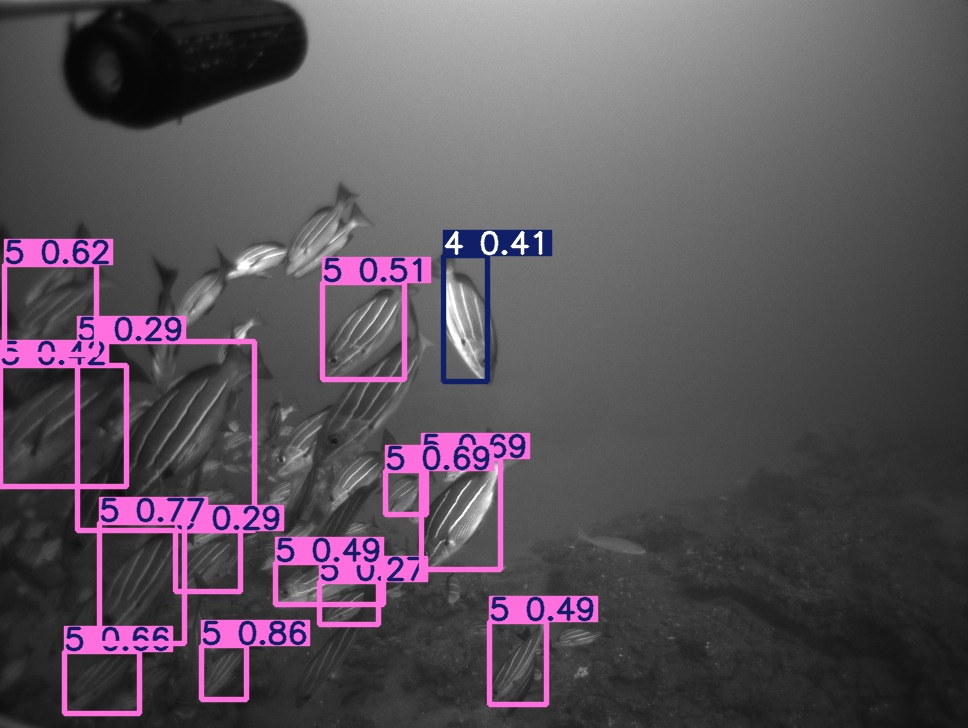

In [22]:
prediction.save('pickles.jpg')
from IPython.display import Image
Image(filename='pickles.jpg') 